In [87]:
%matplotlib notebook

import sys
sys.path.append("../src")


from qanta.tfidf import TfidfGuesser
from qanta.models.dan import DanGuesser, DanModel, DanEncoder, datasets
from qanta.models.timer import Timer

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from IPython.display import display

In [ ]:
import os
print(os.getcwd())
os.chdir("../src")

# Load Models

In [8]:
tfidf_guesser = TfidfGuesser.load(stem=True)
dan_guesser = DanGuesser()

/Users/allen/.pyenv/versions/cmsc723/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/allen/.pyenv/versions/cmsc723/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Load Training/Test Data

In [16]:
os.chdir("qanta")
train_data, dev_data, test_data = datasets()

# Test

In [17]:
question = test_data[0]
question_text = question["text"]
ans = question["page"]

In [19]:
question_text

'One work by this author uses printing, gunpowder, and the compass as symbols of personal ambition, national ambition, and the ambition of the human race to extend its grasp. This thinker described three forms of false learning as "delicate", "contentious", and "fantastical" in categorizing the "distempers" that impede academic progress. This thinker imagined a utopian university called Salomon\'s House, and he likened received systems of philosophy to stage plays that misrepresent the world, and thus labeled them "idols of the theatre". This author of The New Atlantis established the doctrine of inductive, empirical methodology. For 10 points, name this 17th-century English philosopher who wrote Novum Organum and spearheaded the Scientific Revolution.'

In [53]:

def test_model(model):
    SIZE = 200
    results = []
    for idx, question in tqdm_notebook(enumerate(test_data[:SIZE]), total=SIZE):
        question_text = question["text"]
        ans = question["page"]
        guess = dan_guesser.guess(question_text)
        if ans != guess: 
            continue

        text_vector = question_text.split(" ")
        for index in tnrange(1, len(text_vector)):
            err = False
            fragment = " ".join(text_vector[:index])
#             print(fragment)
            try:
                guess = model.guess(fragment)
            except:
                err = True
                break
            if ans == guess:
                break
        if not err:
            progress = index / len(text_vector)
            results.append({"index": idx, "word_index": index, "progress": progress, "length": len(text_vector)})

    return results
            
with Timer() as t:
    results = test_model(dan_guesser)            
print(t)

# for r in results:
#     print(r)

18 minutes 21 seconds
{'index': 0, 'word_index': 32, 'progress': 0.2882882882882883, 'length': 111}
{'index': 1, 'word_index': 63, 'progress': 0.4632352941176471, 'length': 136}
{'index': 4, 'word_index': 107, 'progress': 0.781021897810219, 'length': 137}
{'index': 5, 'word_index': 8, 'progress': 0.06349206349206349, 'length': 126}
{'index': 7, 'word_index': 80, 'progress': 0.6722689075630253, 'length': 119}
{'index': 8, 'word_index': 46, 'progress': 0.4423076923076923, 'length': 104}
{'index': 9, 'word_index': 89, 'progress': 0.644927536231884, 'length': 138}
{'index': 10, 'word_index': 62, 'progress': 0.5636363636363636, 'length': 110}
{'index': 12, 'word_index': 2, 'progress': 0.016, 'length': 125}
{'index': 13, 'word_index': 7, 'progress': 0.05555555555555555, 'length': 126}
{'index': 16, 'word_index': 114, 'progress': 0.8702290076335878, 'length': 131}
{'index': 17, 'word_index': 35, 'progress': 0.23972602739726026, 'length': 146}
{'index': 19, 'word_index': 30, 'progress': 0.2343

In [88]:
df = pd.DataFrame(results)
df.describe()

,index,length,progress,word_index
count,150.000000,150.000000,150.000000,150.000000
mean,104.940000,129.380000,0.349293,45.140000
std,58.587539,9.690284,0.256123,33.352506
min,0.000000,104.000000,0.007092,1.000000
25%,53.250000,123.000000,0.141183,18.000000
50%,111.500000,129.000000,0.272752,35.000000
75%,154.750000,136.000000,0.509705,66.750000
max,199.000000,153.000000,0.992537,141.000000


<IPython.core.display.Javascript object>


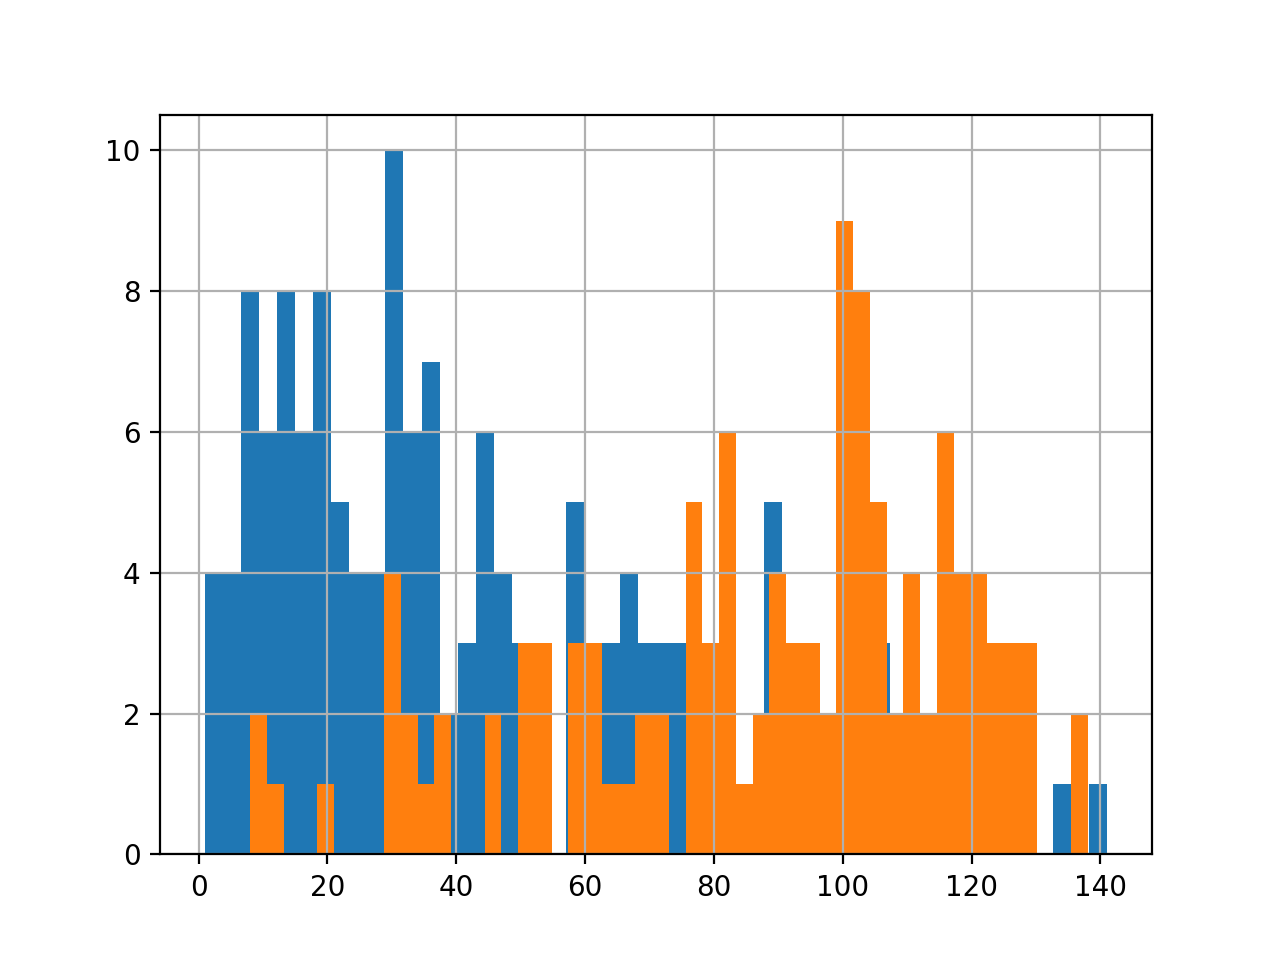

In [93]:
df["word_index"].hist(bins=50)

In [81]:
BUZZ_NUM_GUESSES = 10
BUZZ_THRESHOLD = 0.3

def guess_and_buzz(model, question_text):
    guesses = model.guess([question_text], BUZZ_NUM_GUESSES)[0]
    scores = [guess[1] for guess in guesses]
    buzz = scores[0] / sum(scores) >= BUZZ_THRESHOLD
    return guesses[0][0], buzz


def test_tfidf_model(model):
    SIZE = 200
    results = []
    for idx, question in tqdm_notebook(enumerate(test_data[:SIZE]), total=SIZE, desc="Questions"):
        question_text = question["text"]
        ans = question["page"]
        guess, _ = guess_and_buzz(tfidf_guesser, question_text)
        if ans != guess: 
            continue

        text_vector = question_text.split(" ")
#         for index in tqdm_notebook(range(1, len(text_vector)), total=len(text_vector), leave=False):
        for index in range(1, len(text_vector)):
            err = False
            fragment = " ".join(text_vector[:index])
            guess, _ = guess_and_buzz(tfidf_guesser, fragment)
                
            if ans == guess:
                break
                
        if not err:
            progress = index / len(text_vector)
            results.append({"index": idx, "word_index": index, "progress": progress, "length": len(text_vector)})

    return results
            
with Timer() as t:
    tfidf_results = test_tfidf_model(tfidf_guesser)            
print(t)

# for r in tfidf_results:
#     print(r)

/Users/allen/.pyenv/versions/cmsc723/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


19 minutes 54 seconds
{'index': 0, 'word_index': 59, 'progress': 0.5315315315315315, 'length': 111}
{'index': 1, 'word_index': 71, 'progress': 0.5220588235294118, 'length': 136}
{'index': 4, 'word_index': 96, 'progress': 0.7007299270072993, 'length': 137}
{'index': 5, 'word_index': 87, 'progress': 0.6904761904761905, 'length': 126}
{'index': 6, 'word_index': 53, 'progress': 0.4015151515151515, 'length': 132}
{'index': 7, 'word_index': 78, 'progress': 0.6554621848739496, 'length': 119}
{'index': 9, 'word_index': 118, 'progress': 0.855072463768116, 'length': 138}
{'index': 10, 'word_index': 46, 'progress': 0.41818181818181815, 'length': 110}
{'index': 18, 'word_index': 99, 'progress': 0.7279411764705882, 'length': 136}
{'index': 19, 'word_index': 30, 'progress': 0.234375, 'length': 128}
{'index': 20, 'word_index': 54, 'progress': 0.4090909090909091, 'length': 132}
{'index': 21, 'word_index': 68, 'progress': 0.5190839694656488, 'length': 131}
{'index': 22, 'word_index': 106, 'progress': 0

In [89]:
df2 = pd.DataFrame(tfidf_results)
df2.describe()

,index,length,progress,word_index
count,117.000000,117.000000,117.000000,117.000000
mean,104.683761,129.846154,0.671085,87.213675
std,60.034997,10.121346,0.230832,30.717800
min,0.000000,107.000000,0.056338,8.000000
25%,51.000000,123.000000,0.524590,68.000000
50%,109.000000,130.000000,0.727941,96.000000
75%,158.000000,137.000000,0.855072,110.000000
max,199.000000,153.000000,0.992063,138.000000


In [94]:
df2["word_index"].hist(bins=50)

<IPython.core.display.Javascript object>


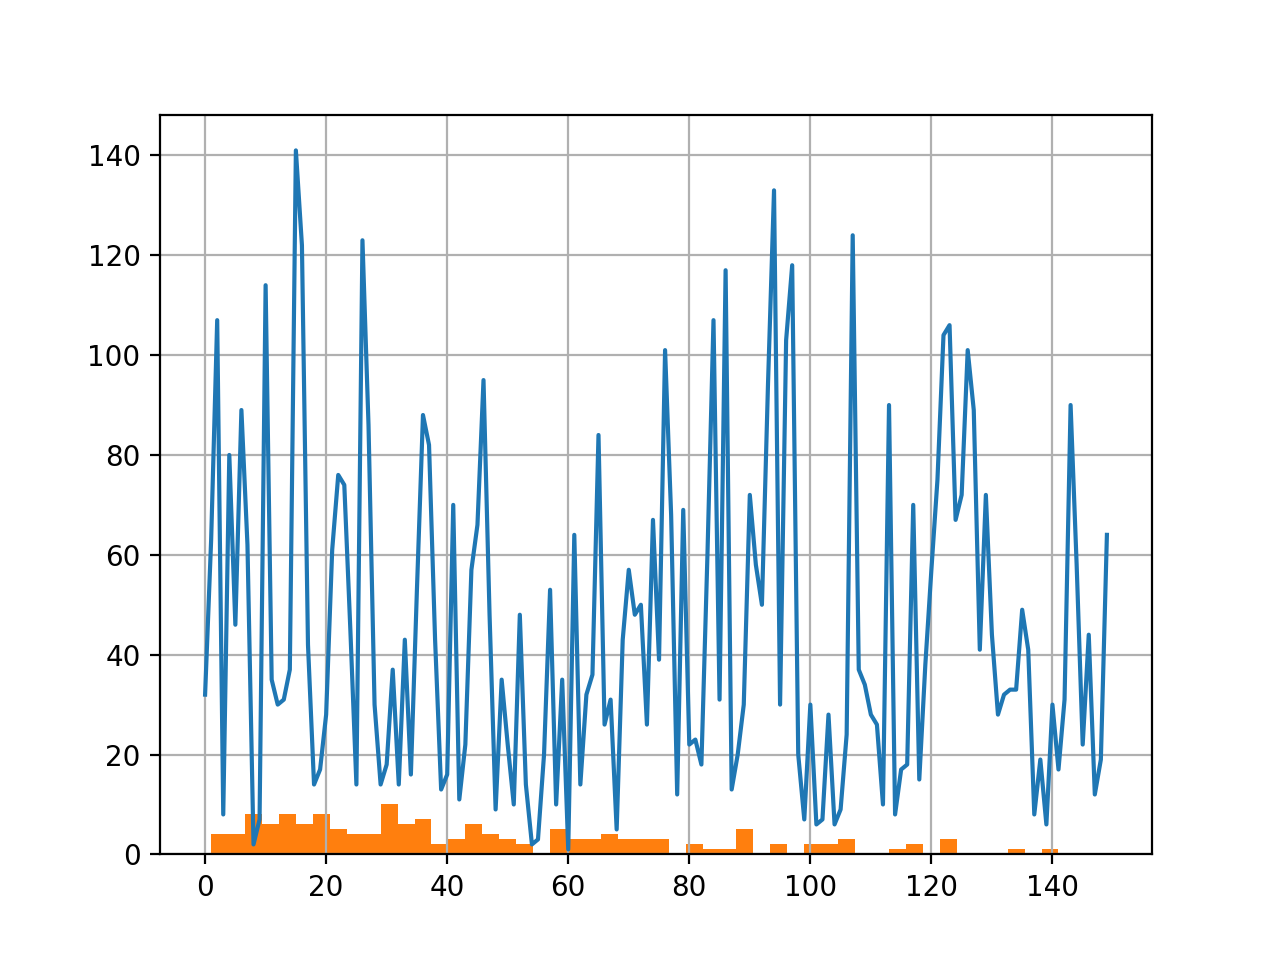

In [91]:
df["word_index"].plot()

In [97]:
df["tfidf_word_index"] = df2["word_index"]

<IPython.core.display.Javascript object>


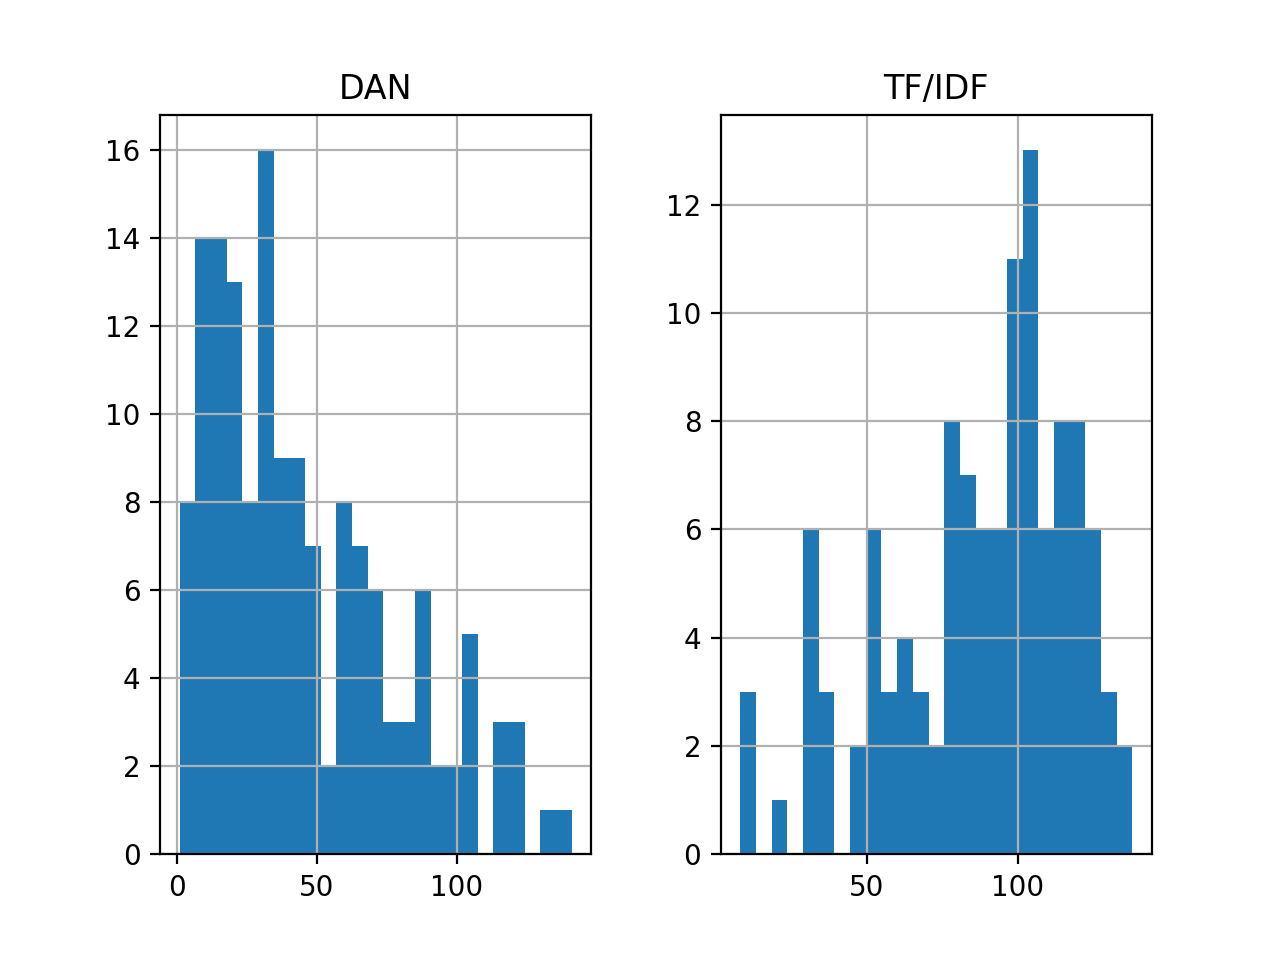

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e148b00>,
      dtype=object)

In [115]:
df.rename(index=str, columns={"word_index": "DAN", "tfidf_word_index": "TF/IDF"})[["DAN", "TF/IDF"]].hist(bins=25)

<IPython.core.display.Javascript object>


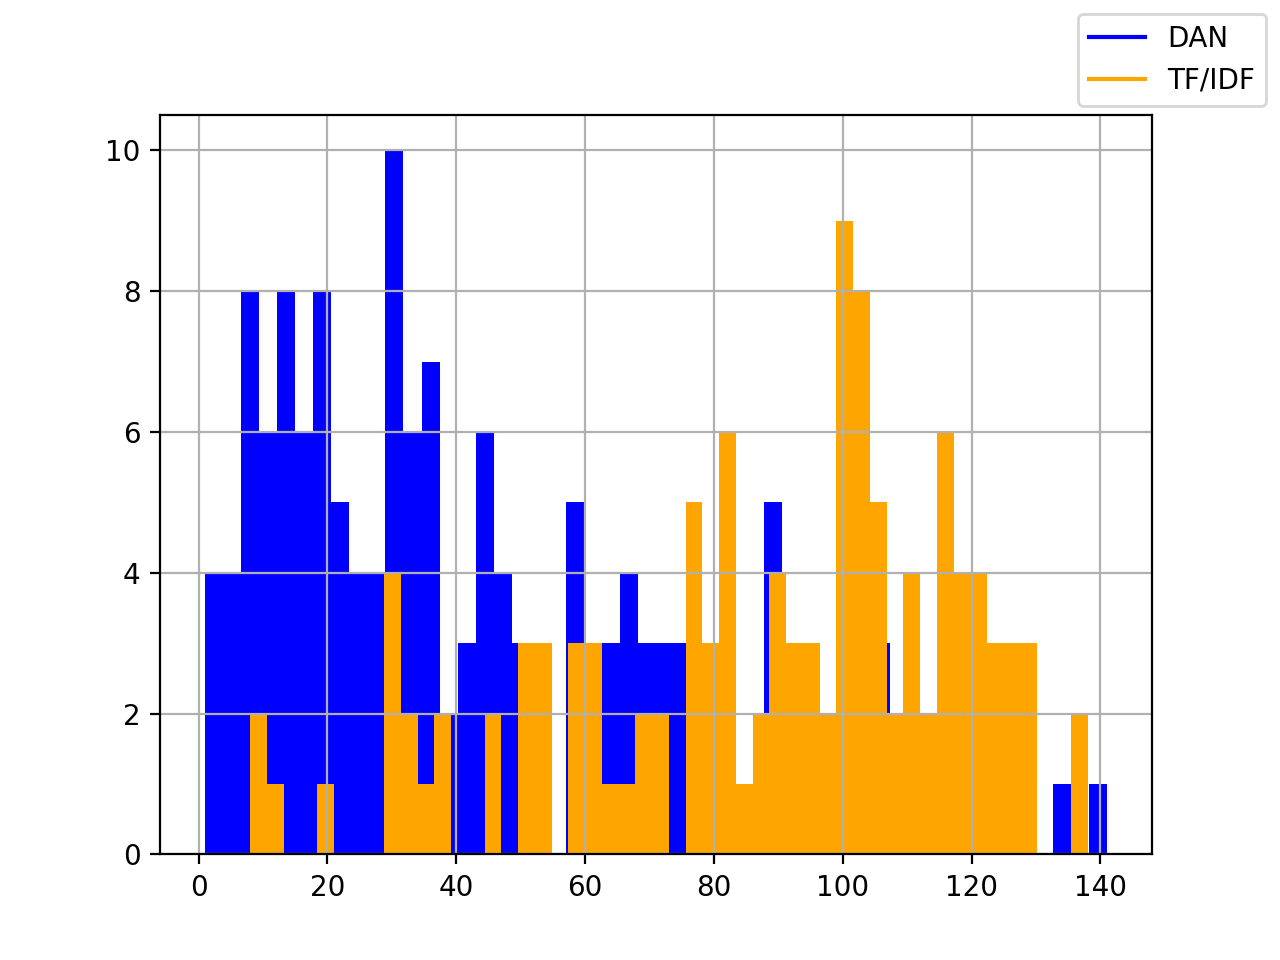

In [112]:
fig, ax = plt.subplots()
df["word_index"].hist(ax=ax, bins=50, color="blue")
df2["word_index"].hist(ax=ax, bins=50, color="orange")
ax.plot([],[], label="DAN", color="blue")
ax.plot([],[], label="TF/IDF", color="orange")
fig.legend()